In [163]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import xarray as xr
import glob
import pyart
import cartopy.crs as ccrs
import zipfile
import warnings
import os
import matplotlib.pyplot as plt
import h5py
import netCDF4 as nc
import matplotlib
import shapely
from cartopy import geodesic
import tqdm
warnings.simplefilter("ignore")

def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01], vmax=60):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143.047172267468; max_lon=146.463827732532; min_lat=-39.2042830440922; max_lat=-36.5063169559078
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149.588054873546; max_lon=152.830745126454; min_lat=-35.0497830440922; max_lat=-32.3518169559078
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151.016761314807; max_lon=154.061238685193; min_lat=-28.9569830440922; max_lat=-26.2590169559078
    elif rid=="66":
        min_lon=151.716232124553; max_lon=154.763767875447; min_lat=-29.0667830440922; max_lat=-26.3688169559078
    elif rid=="28":
        min_lon=151.5; max_lon=154.5; min_lat=-31; max_lat=-28.5     
    elif rid=="4":
        min_lon=150.5; max_lon=153; min_lat=-34; max_lat=-32
    elif rid=="55":
        min_lon=146; max_lon=149; min_lat=-36.5; max_lat=-34            
    elif rid=="27":
        min_lon=135.226736433275; max_lon=138.379263566725; min_lat=-32.5059830440922; max_lat=-29.8080169559078    
        
        
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=vmax)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="^", mew=2, ms=10, color="lightgray", mec="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (dBZ)",fontsize=14)
        cb.ax.tick_params(labelsize=14)        

    return disp
    
def unpack_level1(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1/odim_pvol/"+rid+"/"+str(times[0].year)+"/vol/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[9].split("_")[1][0:8], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)     
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)  
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    if (rid=="27") | (rid=="50"):
        times = [time+dt.timedelta(seconds=-60*10), time+dt.timedelta(seconds=30)]
    else:
        times = [time+dt.timedelta(seconds=-60*6), time+dt.timedelta(seconds=30)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]   
    
    radar_file = pyart.io.read_grid(target_files[-1])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file   
    
def load_radar_l1(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    if (rid=="27") | (rid=="50"):
        times = [time+dt.timedelta(seconds=-10*60), time+dt.timedelta(seconds=2*60)]
    else:
        times = [time+dt.timedelta(seconds=-6*60), time+dt.timedelta(seconds=2*60)]
    unpack_level1(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*.pvol.h5"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2][0:6],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]   
    print(target_files)
    
    radar_file = pyart.aux_io.read_odim_h5(target_files[-1])

    _ = [os.remove(f) for f in target_files]
    
    return radar_file  

def reconstruct_grid(f, group_id):

        #From h5 grid objects (f), reconstruct the radar grid

        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]

        return recon, x, y
    
def plot_refl(row, ax, vmax=60, plot_az=True):
    cnt=0          

    #PLOT REFLECTIVITY, ZOOMED IN TO OBJECT
    disp = plot_radar(row["rid"], row["gust_time_utc"], row["lon"], row["lat"], ax, plot_cbar=True, cax=[0.2,0.05,0.6,0.01], vmax=vmax)            

    t1 = (row.gust_time_utc+dt.timedelta(hours=-12)).strftime("%Y%m%d")
    t2 = (row.gust_time_utc+dt.timedelta(hours=+12)).strftime("%Y%m%d")    
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+\
                     row.rid + "_" + t1 + "_" + t2 + ".h5", "r")

    group_id = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+row.rid + "_" + t1 + "_" + t2 + "_aws.csv")\
                        .query("(uid10=="+str(row.uid)+") & (scan=="+str(row.scan)+")").group_id.iloc[0]
    group_id = group_id.split("/")[0]+"/"+str(int(row.uid))

    mask, x, y = reconstruct_grid(grid, group_id)
    ax.contour(x,y,mask,levels=[0,1],colors="k")    

    x1, x2 = [np.nanmin(np.where(mask==1,x,np.nan)), np.nanmax(np.where(mask==1,x,np.nan))]
    y1, y2 = [np.nanmin(np.where(mask==1,y,np.nan)), np.nanmax(np.where(mask==1,y,np.nan))]    
    ax.set_xlim([x1-0.2,x2+0.2])
    ax.set_ylim([y1-0.2,y2+0.2])
    ax.plot(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],marker="+",ms=14,mew=2,color="k")    
            
def plot_refl_l1(row, ax, sweep, vmax=60, plot_az=True):
    cnt=0  
    
    #PLOT REFLECTIVITY, ZOOMED IN TO OBJECT
    radar = load_radar_l1(row.rid, row.gust_time_utc)        

    t1 = (row.gust_time_utc+dt.timedelta(hours=-12)).strftime("%Y%m%d")
    t2 = (row.gust_time_utc+dt.timedelta(hours=+12)).strftime("%Y%m%d")    
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+\
                     row.rid + "_" + t1 + "_" + t2 + ".h5", "r")

    group_id = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+row.rid + "_" + t1 + "_" + t2 + "_aws.csv")\
                        .query("(uid10=="+str(row.uid)+") & (scan=="+str(row.scan)+")").group_id.iloc[0]
    group_id = group_id.split("/")[0]+"/"+str(int(row.uid))

    mask, x, y = reconstruct_grid(grid, group_id)
    ax.contour(x,y,mask,levels=[0,1],colors="k")    

    if row.gust_time_utc == pd.to_datetime(dt.datetime(2014,1,23,5)):
        x1, x2 = [row.lon-0.5,row.lon+0.5]
        y1, y2 = [row.lat-0.5,row.lat+0.5]
        ax.set_xlim([x1, x2])
        ax.set_ylim([y1, y2])        
    else:
        x1, x2 = [np.nanmin(np.where(mask==1,x,np.nan)), np.nanmax(np.where(mask==1,x,np.nan))]
        y1, y2 = [np.nanmin(np.where(mask==1,y,np.nan)), np.nanmax(np.where(mask==1,y,np.nan))]    
        x1, x2 = [x1-0.2, x2+0.2]
        y1, y2 = [y1-0.2, y2+0.2]

    disp = pyart.graph.RadarMapDisplay(radar)
    disp.plot_ppi_map("reflectivity",sweep=sweep,resolution="10m",min_lat=y1, max_lat=y2, min_lon=x1, max_lon=x2,
                     colorbar_flag=False, vmin=0, vmax=vmax)

    ax.plot(radar_file.longitude["data"][0],radar_file.latitude["data"][0],marker="+",ms=14,mew=2,color="k")    
    ax.plot(row.lon, row.lat, marker="^", mew=2, ms=10, color="lightgray", mec="k")
    
def plot_vel_shear(df, sub_row, figsize, outname, titles, plot_az=True):
    cnt=0  
    plt.figure(figsize=figsize)
    for index, row in tqdm.tqdm(df.iterrows()):
        

        #PLOT REFLECTIVITY, ZOOMED IN TO OBJECT
        ax=plt.subplot(sub_row,3,(cnt*3)+1)
        if cnt==(sub_row-1):
            disp = plot_radar(row["rid"], row["gust_time_utc"], row["lon"], row["lat"], ax, plot_cbar=True, cax=[0.125,0.05,0.2,0.01])  
        else:
            disp = plot_radar(row["rid"], row["gust_time_utc"], row["lon"], row["lat"], ax, plot_cbar=False)              

        t1 = (row.gust_time_utc+dt.timedelta(hours=-12)).strftime("%Y%m%d")
        t2 = (row.gust_time_utc+dt.timedelta(hours=+12)).strftime("%Y%m%d")    
        grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+\
                         row.rid + "_" + t1 + "_" + t2 + ".h5", "r")

        group_id = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+row.rid + "_" + t1 + "_" + t2 + "_aws.csv")\
                            .query("(uid10=="+str(row.uid)+") & (scan=="+str(row.scan)+")").group_id.iloc[0]
        group_id = group_id.split("/")[0]+"/"+str(int(row.uid))

        mask, x, y = reconstruct_grid(grid, group_id)
        ax.contour(x,y,mask,levels=[0,1],colors="k")    

        x1, x2 = [np.nanmin(np.where(mask==1,x,np.nan)), np.nanmax(np.where(mask==1,x,np.nan))]
        y1, y2 = [np.nanmin(np.where(mask==1,y,np.nan)), np.nanmax(np.where(mask==1,y,np.nan))]    
        ax.set_xlim([x1-0.2,x2+0.2])
        ax.set_ylim([y1-0.2,y2+0.2])
        ax.plot(disp.grid.origin_longitude["data"][0],disp.grid.origin_latitude["data"][0],marker="+",ms=14,mew=2,color="k")    

        ax2=plt.subplot(sub_row,3,(cnt*3)+2)
        ax3=plt.subplot(sub_row,3,(cnt*3)+3)
        
        if "azshear" in list(disp.grid.fields.keys()):
            
            #PLOT AZSHEAR STRAIGHT FROM RQ0, ZOOMED IN TO OBJECT    
            t=disp.grid.to_xarray().time.values[0]

            if plot_az:
                x,y=np.meshgrid(disp.grid.to_xarray().lon.values, disp.grid.to_xarray().lat.values)
                z=np.abs(disp.grid.to_xarray().sel({"z":slice(2000,6000)}).azshear).max("z").values.squeeze()
                p=ax2.contourf(x,y,z,levels=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5],extend="max",cmap=plt.get_cmap("Reds"))
                #plt.colorbar(p,ax=ax2)
                ax2.contour(x,y,mask,levels=[0,1],colors="k")    

                #vals = np.where((mask==1) & (disp.grid.to_xarray().corrected_reflectivity.max("z").values >= 30), 
                #     (np.abs(disp.grid.to_xarray().sel({"z":slice(2000,6000)}).azshear)).max("z"), np.nan)    
                #ax.set_title("99.5th percentile: "+str(np.round(np.nanpercentile(vals,99.5),1)) + "\n "+\
                 #            "Max: "+str(np.round(np.nanmax(vals),1)))
                # if cnt==0:
                #     ax2.set_title()
                #     ax3.set_title()
                ax2.set_title(titles[cnt]+disp.grid.to_xarray().time.values[0].strftime("%Y-%m-%d %H:%M") + " UTC")   
                

                ax2.set_xlim([x1-0.2,x2+0.2])
                ax2.set_ylim([y1-0.2,y2+0.2])
                
                if cnt==(sub_row-1):                
                    cb=plt.colorbar(p, cax=plt.axes([0.42,0.05,0.2,0.01]), orientation="horizontal", extend="both",ticks=[1,2,3,4])
                    cb.set_label("2-6 km max azimuthal\nshear (s$^{-1} x 10^{-3}$)",fontsize=14)
                    cb.ax.tick_params(labelsize=14)           

                #PLOT VELOCITY
                x,y=np.meshgrid(disp.grid.to_xarray().lon.values, disp.grid.to_xarray().lat.values)
                z=disp.grid.to_xarray().sel({"z":2500}).corrected_velocity.values.squeeze()
                p=ax3.contourf(x,y,z,levels=np.arange(-20,22,2),extend="both",cmap=plt.get_cmap("RdBu"))
                #plt.colorbar(p,ax=ax3)
                ax3.set_xlim([x1-0.2,x2+0.2])
                ax3.set_ylim([y1-0.2,y2+0.2])    
                ax3.contour(x,y,mask,levels=[0,1],colors="k")  
                
                if cnt==(sub_row-1):
                    cb=plt.colorbar(p, cax=plt.axes([0.67,0.05,0.2,0.01]), orientation="horizontal", extend="both")
                    cb.set_label("Doppler radial velocity\naway from radar (m/s)",fontsize=14)
                    cb.ax.tick_params(labelsize=14)                   
                

        else: 
            pass    
        cnt=cnt+1
        
    plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/"+outname+".jpeg",bbox_inches="tight",dpi=400)

In [2]:
details_list = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details_list["gust_time_utc"] = pd.DatetimeIndex(details_list.gust_time_utc)
details_list["rid"] = details_list.rid.astype(str)
details_list["stn_id"] = details_list.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

6it [00:13,  2.24s/it]


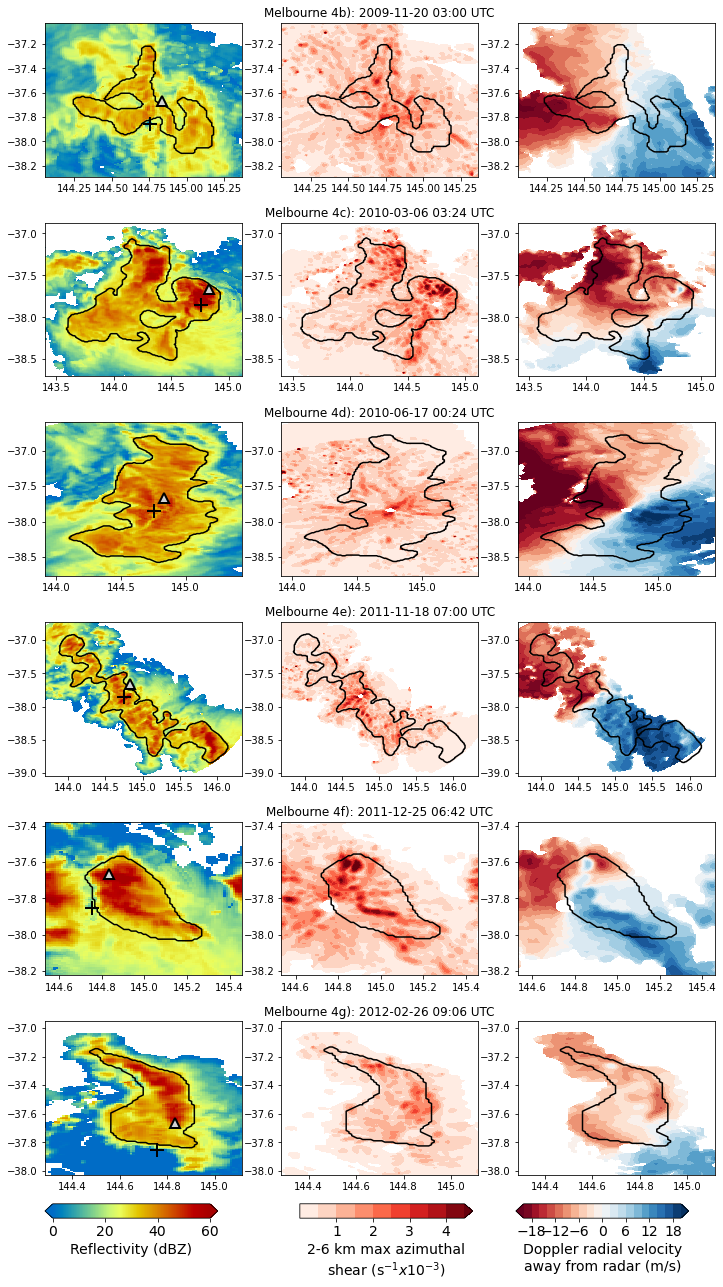

In [171]:
titles = ["Melbourne 4b): ","Melbourne 4c): ","Melbourne 4d): ","Melbourne 4e): ","Melbourne 4f): ","Melbourne 4g): "]
plot_vel_shear(details_list.loc[1:6],6,[12,20],"figS1a",titles)
plt.subplots_adjust(hspace=0.3,bottom=0.08)

6it [00:13,  2.20s/it]


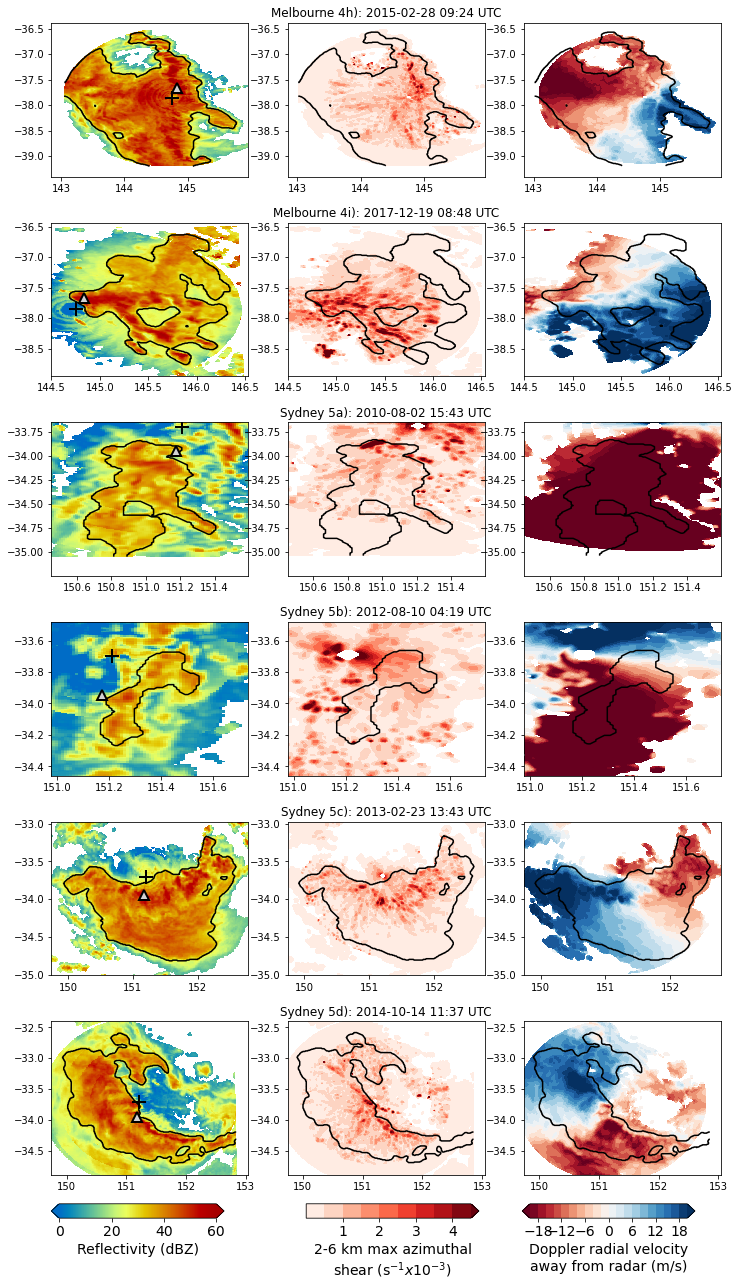

In [172]:
titles = ["Melbourne 4h): ","Melbourne 4i): ","Sydney 5a): ","Sydney 5b): ","Sydney 5c): ","Sydney 5d): "]
plot_vel_shear(details_list.loc[7:12],6,[12,20],"figS1b",titles)
plt.subplots_adjust(hspace=0.3,bottom=0.08)

6it [00:19,  3.26s/it]


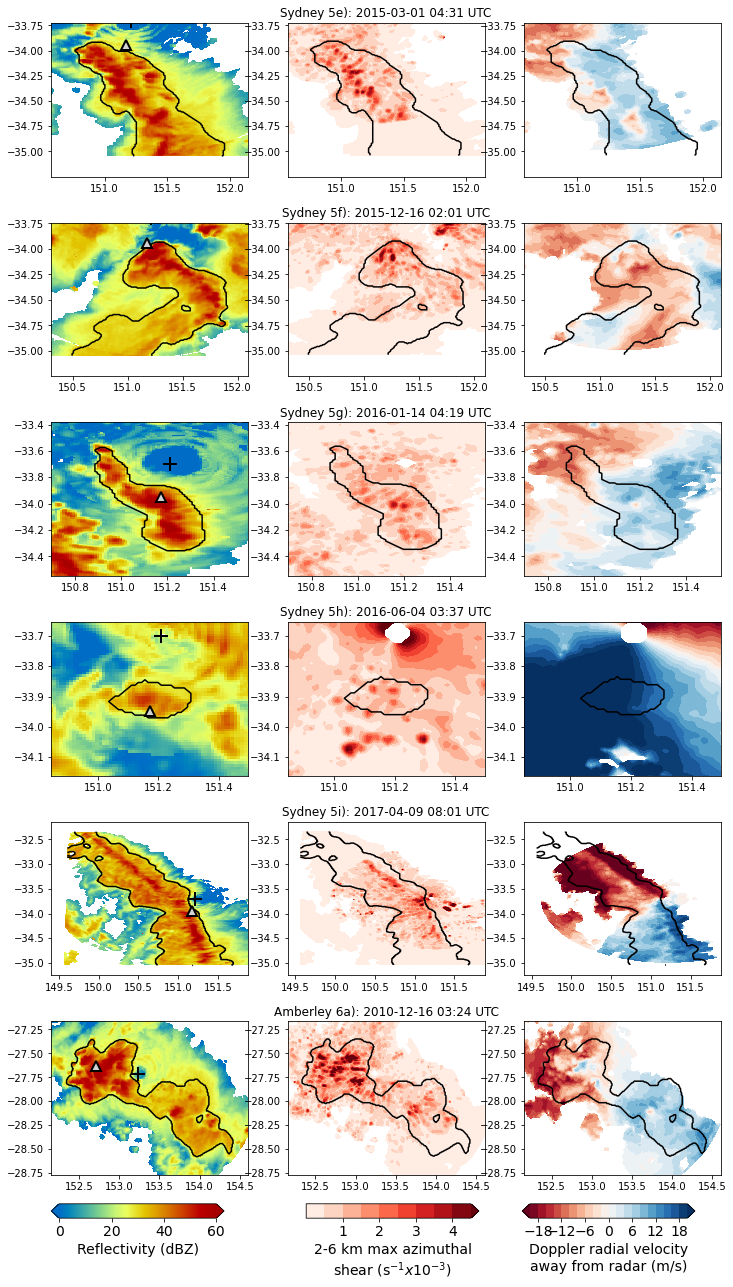

In [173]:
titles = ["Sydney 5e): ","Sydney 5f): ","Sydney 5g): ","Sydney 5h): ","Sydney 5i): ","Amberley 6a): "]
plot_vel_shear(details_list.loc[13:18],6,[12,20],"figS1c",titles)
plt.subplots_adjust(hspace=0.3,bottom=0.08)

3it [00:10,  3.49s/it]


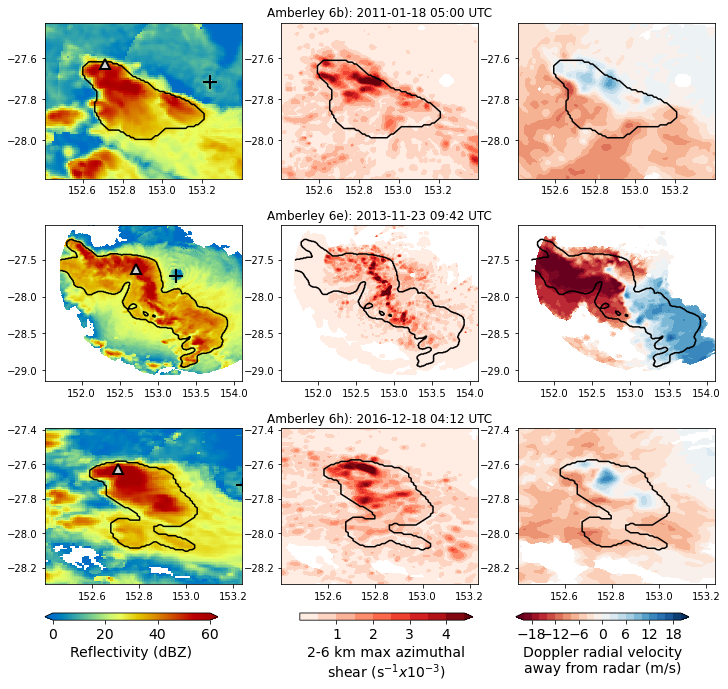

In [174]:
titles = ["Amberley 6b): ","Amberley 6e): ","Amberley 6h): "]
plot_vel_shear(details_list.loc[19:21],3,[12,10],"figS1d",titles)
plt.subplots_adjust(hspace=0.3,bottom=0.1)

['/scratch/eg3/ab4502/tint/50_20111007_192146.pvol.h5'
 '/scratch/eg3/ab4502/tint/50_20111007_193146.pvol.h5']
['/scratch/eg3/ab4502/tint/50_20131018_040152.pvol.h5']
['/scratch/eg3/ab4502/tint/50_20140123_045149.pvol.h5'
 '/scratch/eg3/ab4502/tint/50_20140123_050150.pvol.h5']
['/scratch/eg3/ab4502/tint/50_20160129_042152.pvol.h5']
['/scratch/eg3/ab4502/tint/50_20180213_070155.pvol.h5']


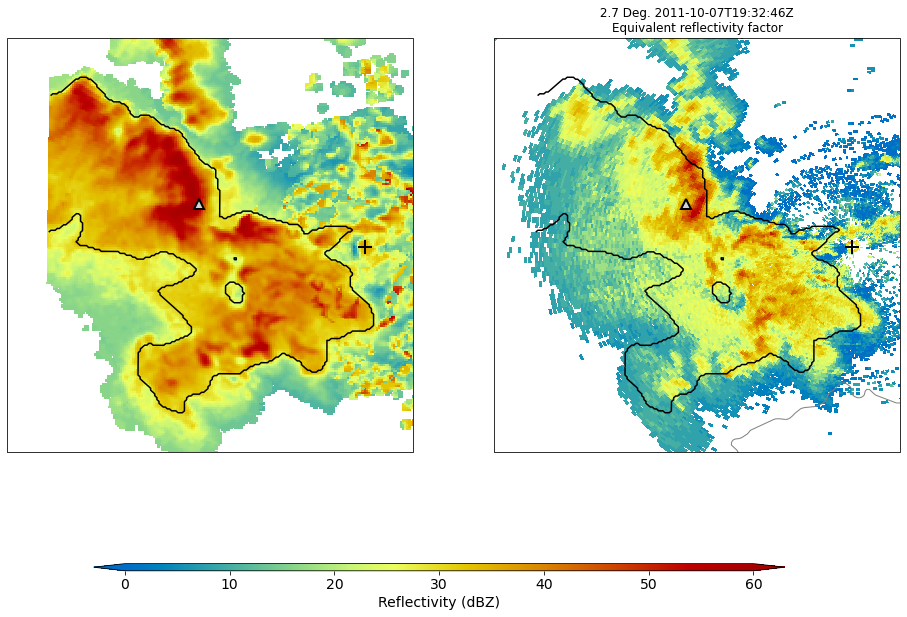

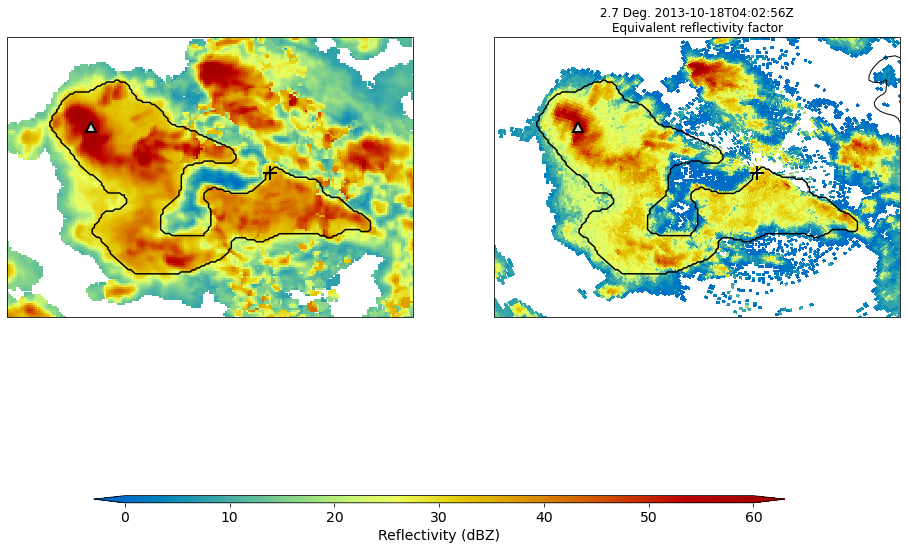

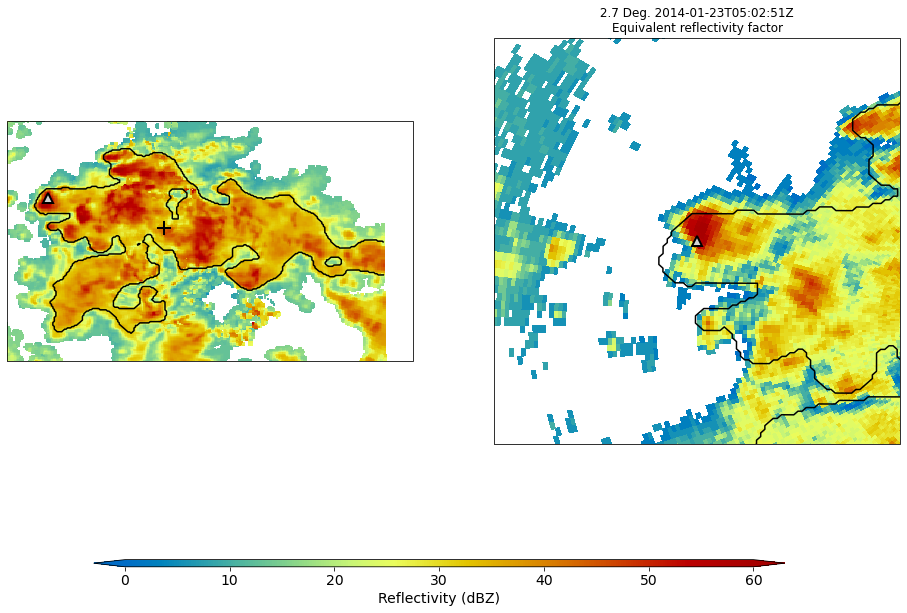

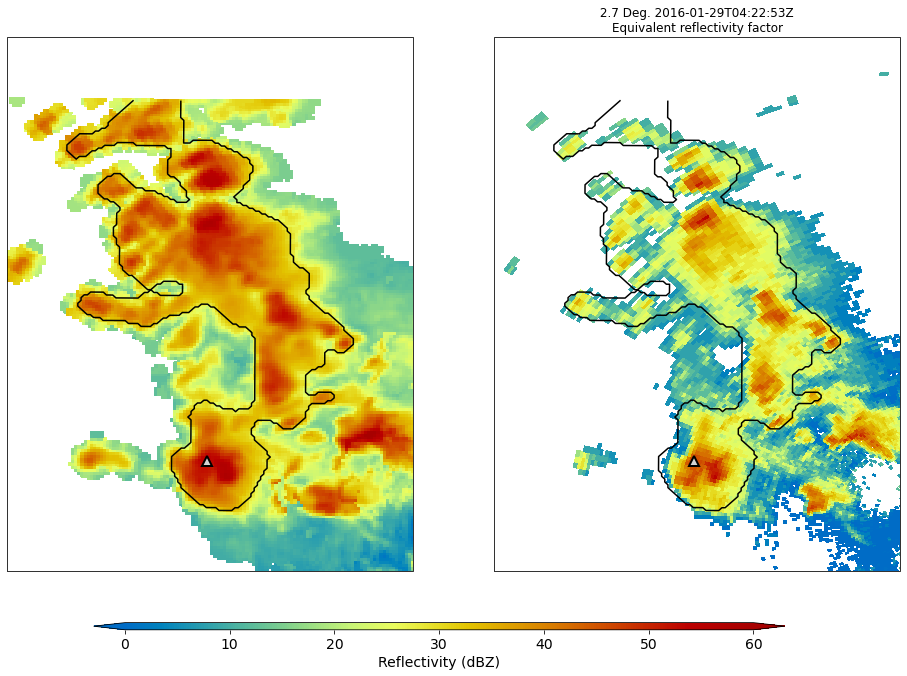

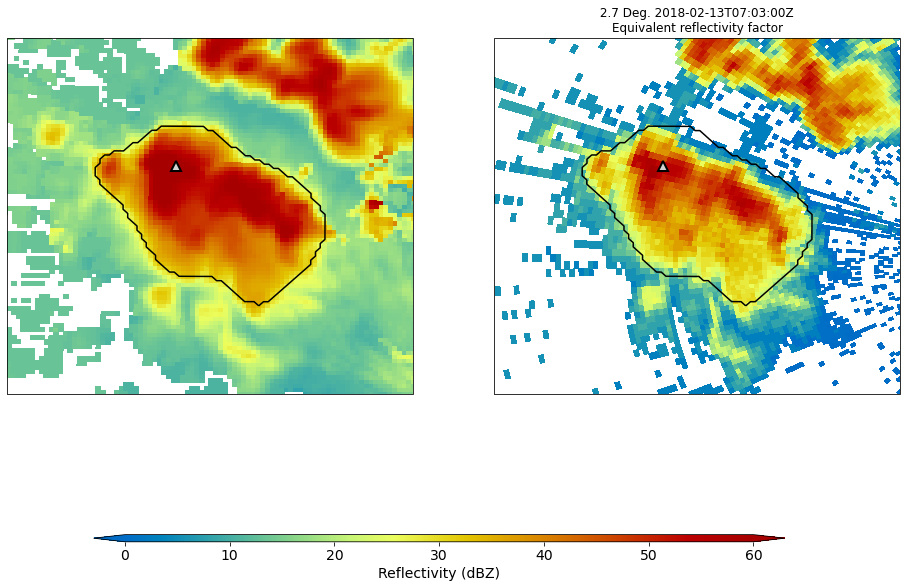

In [162]:
for index, row in details_list[details_list.stn_name=="Oakey"].iterrows():
    
    plt.figure(figsize=[16,10])        
    ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())        
    plot_refl(row, ax, vmax=60)    
    
    ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())        
    plot_refl_l1(row, ax, sweep=3, vmax=60)

['/scratch/eg3/ab4502/tint/27_20071027_090002.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20081209_061002.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20101207_092002.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20111108_094001.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20120129_044001.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20121130_083001.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20141031_075005.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20151207_111004.pvol.h5'
 '/scratch/eg3/ab4502/tint/27_20151207_112004.pvol.h5']
['/scratch/eg3/ab4502/tint/27_20171218_113002.pvol.h5']


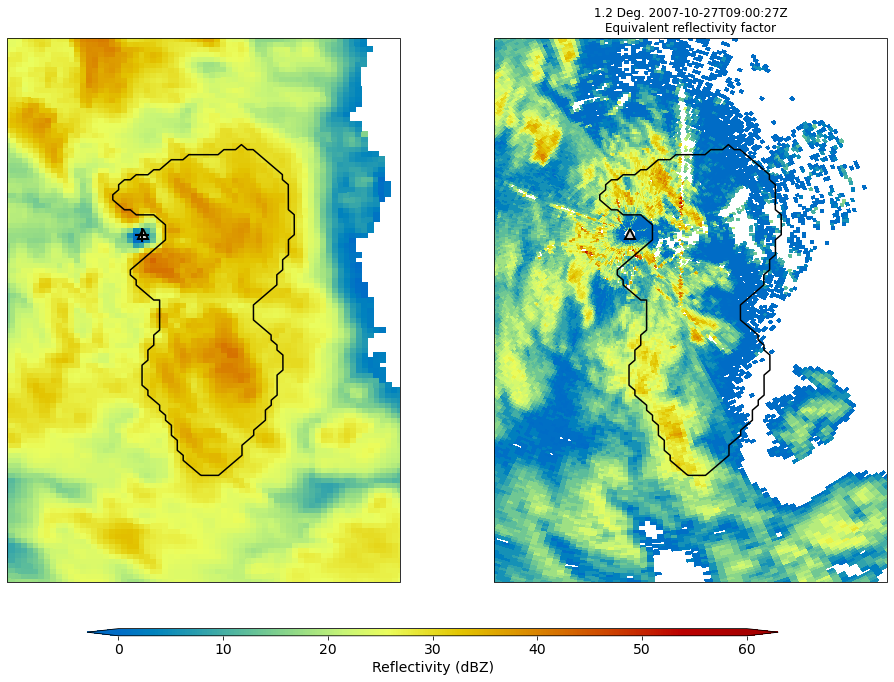

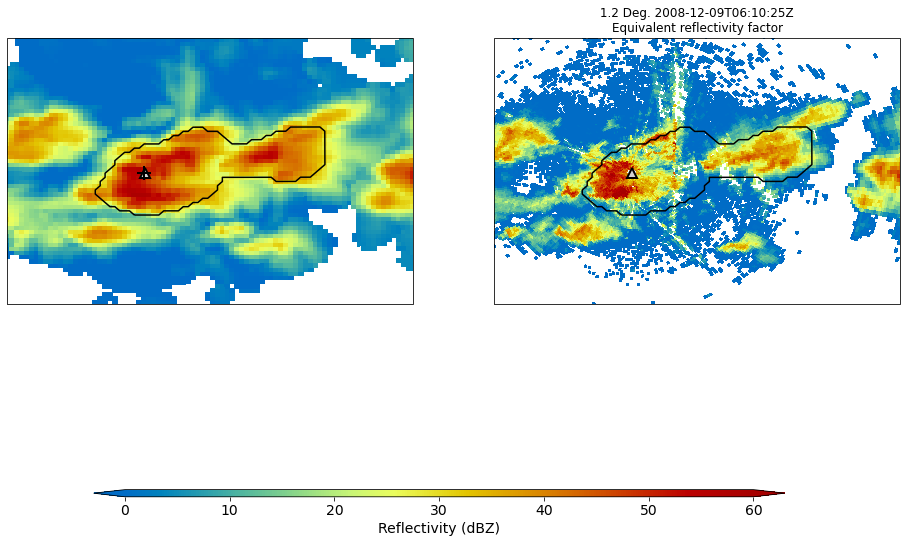

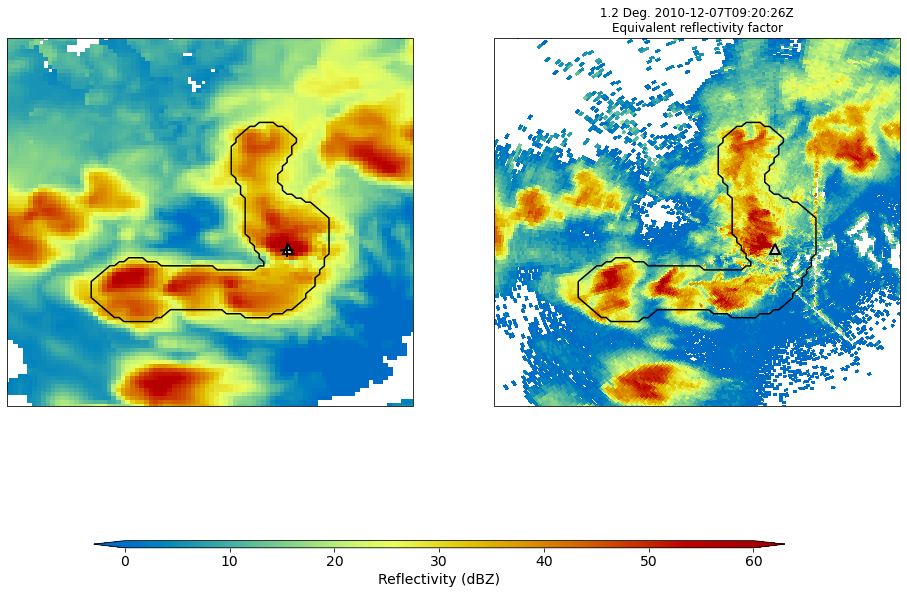

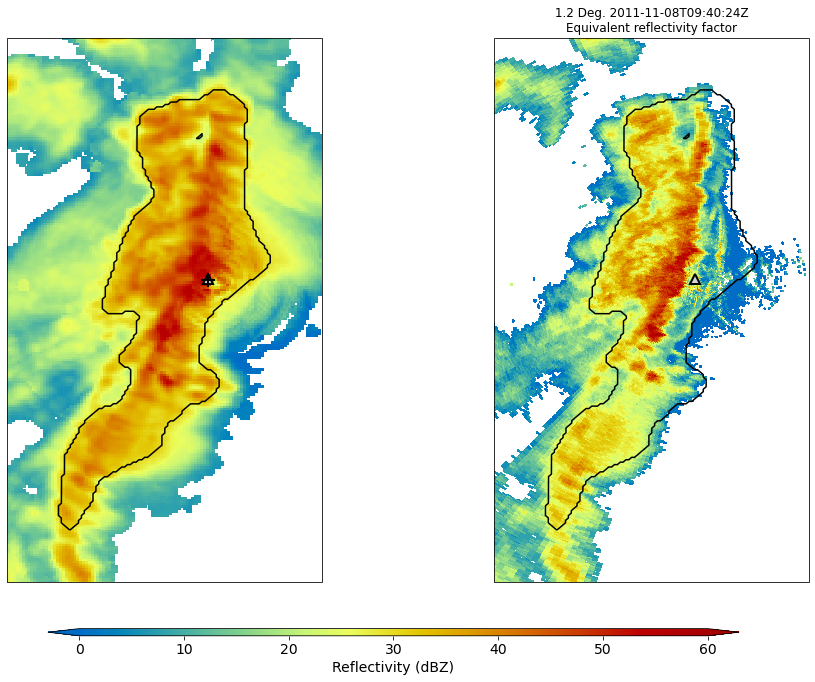

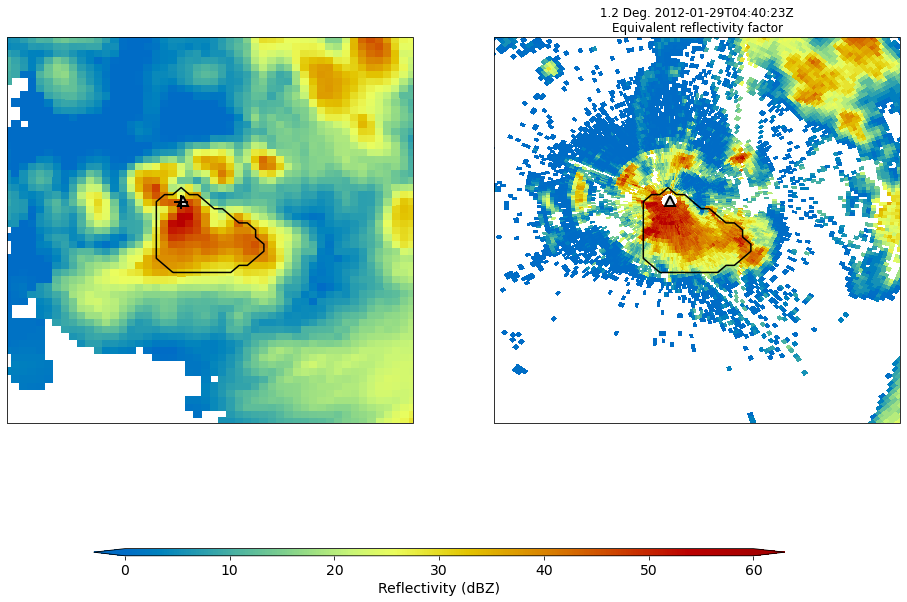

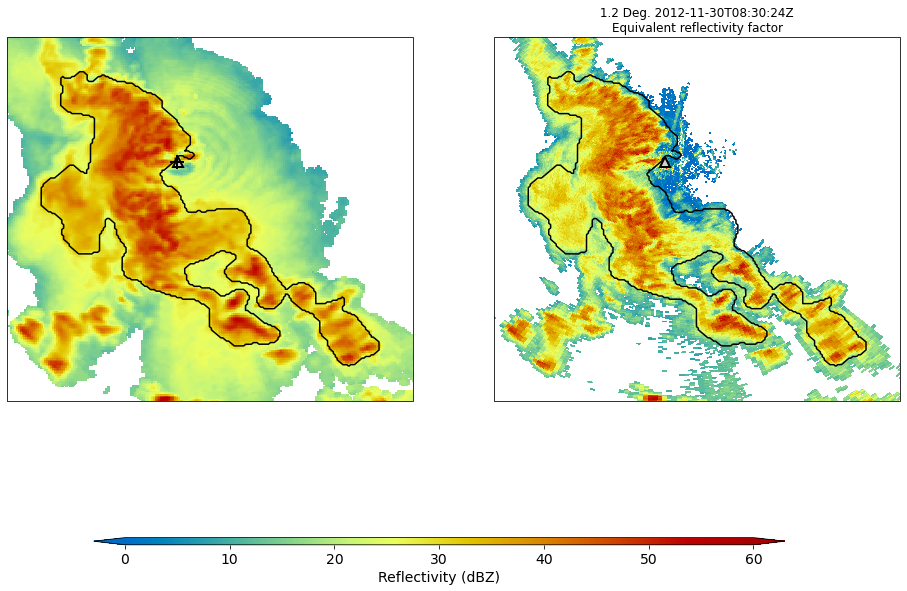

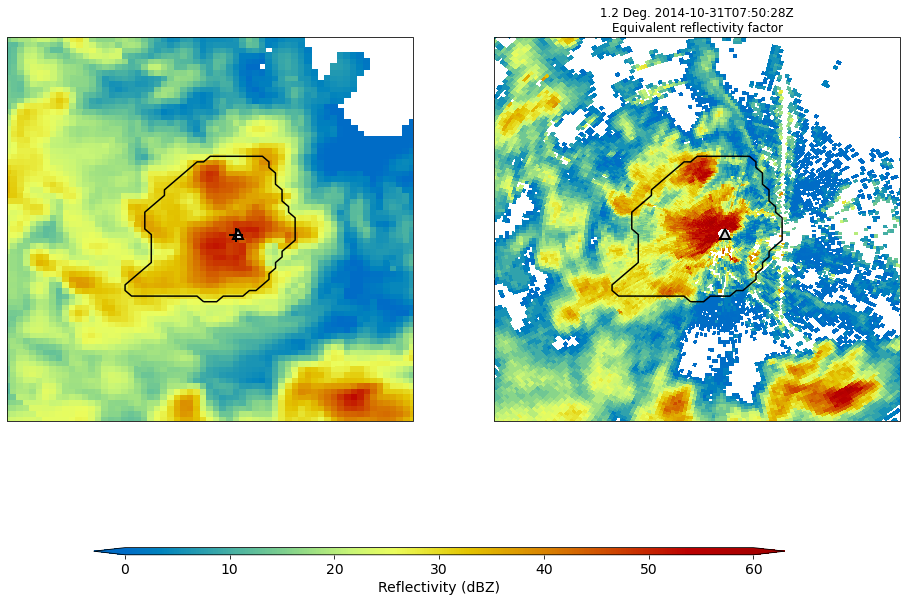

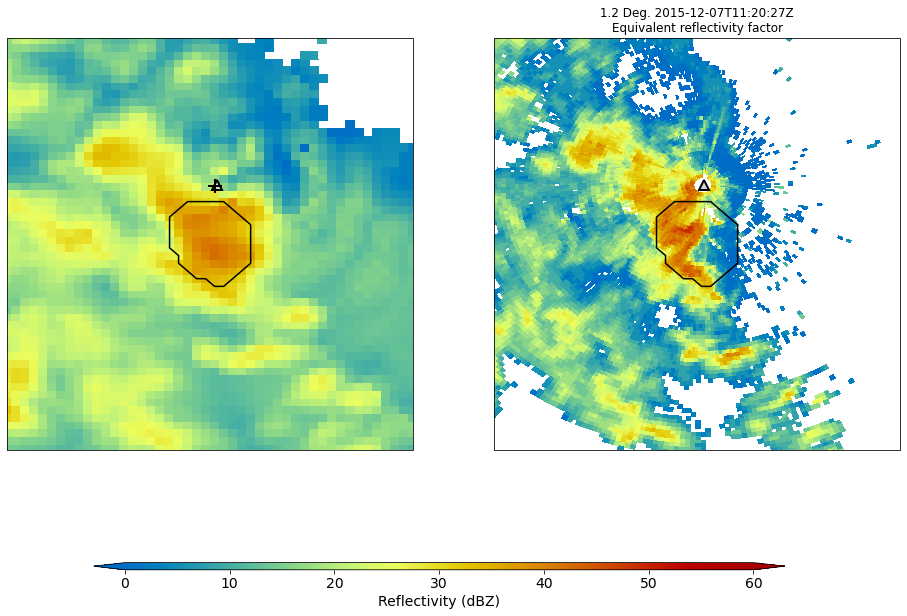

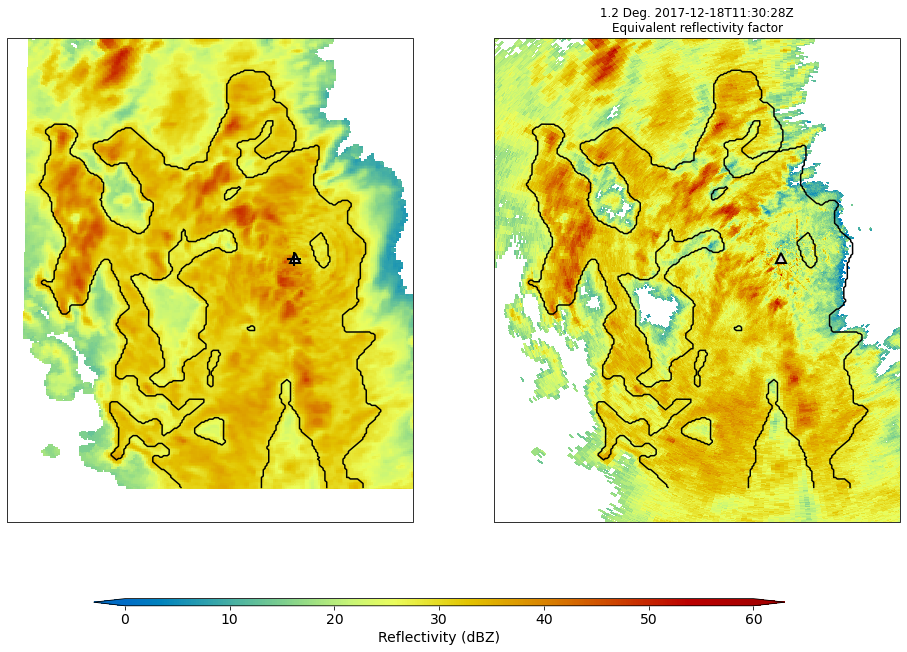

In [160]:
for index, row in details_list[details_list.stn_name=="Woomera"].iterrows():
    
    plt.figure(figsize=[16,10])        
    ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())        
    plot_refl(row, ax)    
    
    ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())        
    plot_refl_l1(row, ax, sweep=1)